## Boosting LightGBM strategy with Reinforcement Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class UCB1:
    def __init__(self, num_arms, ci):
        self.num_arms = num_arms
        self.counts = np.zeros(num_arms)  # Number of times each arm was pulled
        self.values = np.zeros(num_arms)  # Estimated value of each arm
        self.total_counts = 0  # Total number of arm pulls
        self.C = ci  # confidence interval
        self.sigma = 0

    def select_arm(self):
        # Explore all arms at least once
        if 0 in self.counts:
            return np.random.choice(np.where(self.counts == 0)[0])
        ucb_values = self.values + np.sqrt(
            self.C * np.log(self.total_counts) / self.counts
        )
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_counts += 1
        n = self.counts[arm]
        value = self.values[arm]
        # Update the estimated value of the arm using a running average
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

In [3]:
strategy = pd.read_csv("../data/processed/strategy_200.csv")

In [4]:
known_rewards = []
now_date = []
undrelying_return = []
save_average_date_of_option_set = 0
metric = "bare"
for i in strategy["exp_date"].unique():
    future = strategy[strategy["exp_date"] > i]
    past = strategy[strategy["exp_date"] <= i]
    now = strategy[strategy["exp_date"] == i]
    last_reward = now[metric].values.sum()
    known_rewards.append(last_reward)
    now_date.append(i)
    now_underlying = now["final_price"].iloc[0]
    try:
        before_underlying = past[past["Date"] == save_average_date_of_option_set][
            "final_price"
        ].values[0]
        undrelying_return.append(now_underlying - before_underlying)
    except IndexError:
        undrelying_return.append(0)
    save_average_date_of_option_set = now["Date"].iloc[int(len(now["Date"]) / 2) - 1]

In [5]:
data = {
    "Date_At_Expiration": now_date,
    "Underlying_Absolute_Return": undrelying_return,
    "Known_Reward": known_rewards,
}
reward_df = pd.DataFrame(data)

reward_df.iloc[:, 1:].corr()  # type: ignore

,Underlying_Absolute_Return,Known_Reward
Underlying_Absolute_Return,1.000000,0.439178
Known_Reward,0.439178,1.000000


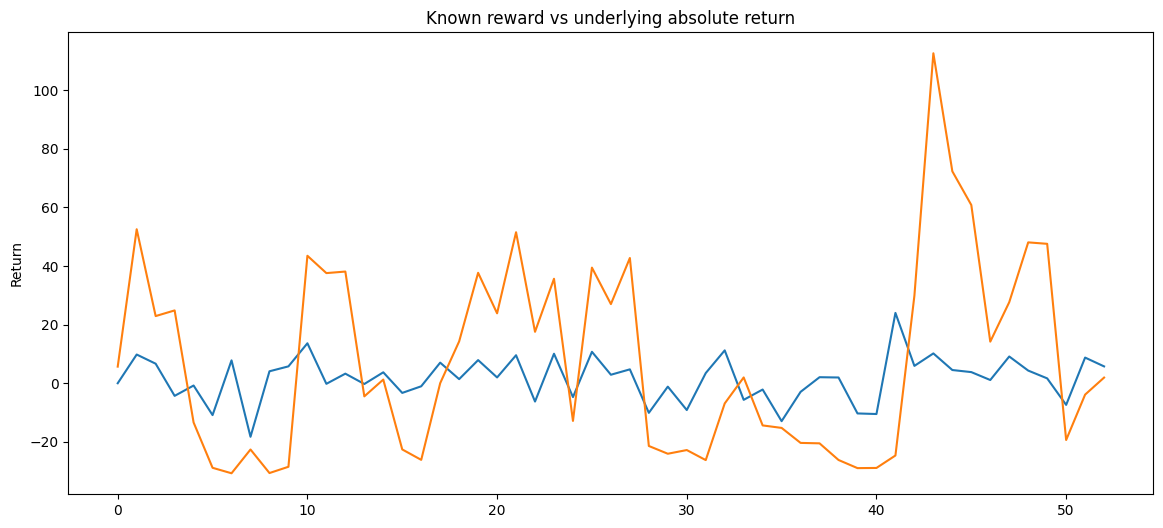

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(reward_df["Underlying_Absolute_Return"], label="Underlying Abs Return")
plt.plot(reward_df["Known_Reward"], label="Known Reward")
plt.title("Known reward vs underlying absolute return")
plt.ylabel("Return")
plt.show()

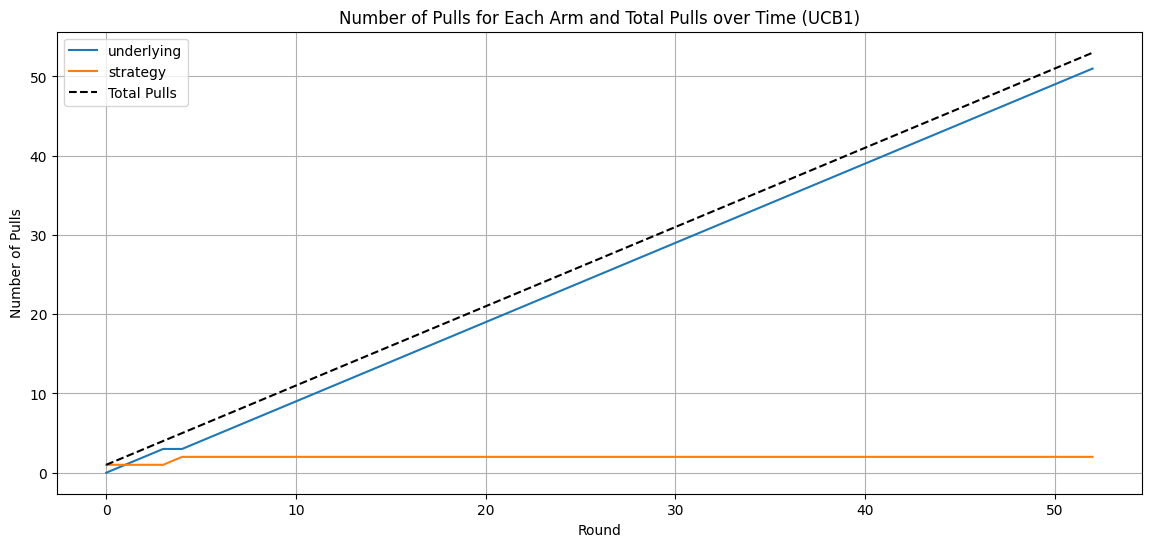

In [7]:
# Simulate UCB1 algorithm
num_arms = 2
ci = 3
num_rounds = len(reward_df)
ucb = UCB1(num_arms, ci)

# Arrays to store the number of times each arm is pulled and the total number of pulls
arm_pulls = np.zeros((num_arms, num_rounds))
total_pulls = np.zeros(num_rounds)
save_arm = []
for i in range(num_rounds):
    arm_to_pull = ucb.select_arm()
    # max if avoid risk
    reward = reward_df.iloc[i, arm_to_pull + 1]
    ucb.update(arm_to_pull, reward)

    arm_pulls[:, i] = ucb.counts
    total_pulls[i] = ucb.total_counts
    save_arm.append(arm_to_pull)
list_of_arms = ["underlying", "strategy"]

# Plotting
plt.figure(figsize=(14, 6))
for arm_index in range(num_arms):
    plt.plot(arm_pulls[arm_index], label=list_of_arms[arm_index])

plt.plot(total_pulls, label="Total Pulls", color="black", linestyle="--")
plt.xlabel("Round")
plt.ylabel("Number of Pulls")
plt.title("Number of Pulls for Each Arm and Total Pulls over Time (UCB1)")
plt.legend()
plt.grid(True)
plt.show()

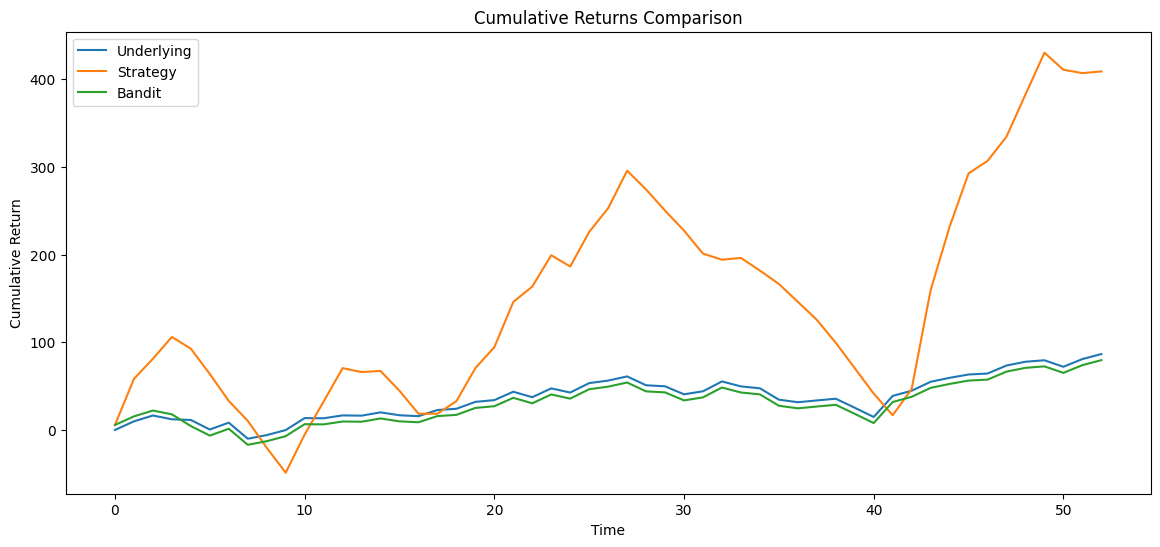

In [8]:
reward_df["bandit_choice"] = save_arm


# Define function to create bandit_return column
def calculate_bandit_return(row):
    if row["bandit_choice"] == 0:
        return row["Underlying_Absolute_Return"]
    elif row["bandit_choice"] == 1:
        return row["Known_Reward"]


# Apply function to create bandit_return column
reward_df["bandit_return"] = reward_df.apply(calculate_bandit_return, axis=1)


reward_df["Underlying_Cumulative_Return"] = reward_df[
    "Underlying_Absolute_Return"
].cumsum()
reward_df["Strategy_Cumulative_Return"] = reward_df["Known_Reward"].cumsum()
reward_df["Bandit_Cumulative_Return"] = reward_df["bandit_return"].cumsum()
plt.figure(figsize=(14, 6))
plt.plot(reward_df["Underlying_Cumulative_Return"], label="Underlying")
plt.plot(reward_df["Strategy_Cumulative_Return"], label="Strategy")
plt.plot(reward_df["Bandit_Cumulative_Return"], label="Bandit")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Comparison")
plt.show()